In [37]:
import os

subj = "Subj1"
exp = "exp_final2"
print_obj = 29
os.makedirs(f"{subj}/{exp}", exist_ok = True)

### Imports

In [27]:
%load_ext autoreload
%autoreload 2

import warnings
import collections
warnings.filterwarnings("ignore")

import mne
import tqdm
import scipy
import numpy
import pandas
import scipy.stats
import gtda.curves
import tqdm.contrib
import gtda.plotting
import gtda.homology
import gtda.diagrams
import gtda.time_series
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
pandas.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
FILTERING_PERCENTILE = 10

CHANNEL_STRIDE = 3
CHANNEL_MAX_TIME_DELAY = 20
CHANNEL_MAX_DIMENSION = 20
CHANNEL_HOMOLOGY_DIMENSIONS = [ 1, 2 ]
CHANNEL_READ_EMBEDDER_PARAMS_FROM_DISK = False

DISSIM_DIMENSION = 50
DISSIM_TIME_DELAY = 1
DISSIM_STRIDE = 20
DISSIM_HOMOLOGY_DIMENSIONS = [ 1, 2, 3, 4, 5 ]

OVERALL_DIMENSION = 5
OVERALL_TIME_DELAY = 11
OVERALL_STRIDE = 3
OVERALL_HOMOLOGY_DIMENSIONS = [ 1, 2, 3 ]

SILHOUETTE_POWERS = [ 1, 2 ]
AMPLITUDE_METRICS = [
    { "id": "bottleneck", "metric": "bottleneck", "metric_params": { } },

    { "id": "wasserstein-1", "metric": "wasserstein", "metric_params": { "p": 1 } },
    { "id": "wasserstein-2", "metric": "wasserstein", "metric_params": { "p": 2 } },

    { "id": "betti-1", "metric": "betti", "metric_params": { "p": 1, 'n_bins': -1 } },
    { "id": "betti-2", "metric": "betti", "metric_params": { "p": 2, 'n_bins': -1 } },
    
    { "id": "landscape-1-1", "metric": "landscape", "metric_params": { "p": 1, "n_layers": 1, 'n_bins': -1 } },
    { "id": "landscape-1-2", "metric": "landscape", "metric_params": { "p": 1, "n_layers": 2, 'n_bins': -1 } },
    { "id": "landscape-2-1", "metric": "landscape", "metric_params": { "p": 2, "n_layers": 1, 'n_bins': -1 } },
    { "id": "landscape-2-2", "metric": "landscape", "metric_params": { "p": 2, "n_layers": 2, 'n_bins': -1 } },

    { "id": "silhouette-1-1", "metric": "silhouette", "metric_params": { "p": 1, "power": 1, 'n_bins': -1 } },
    { "id": "silhouette-1-2", "metric": "silhouette", "metric_params": { "p": 1, "power": 2, 'n_bins': -1 } },
    { "id": "silhouette-2-1", "metric": "silhouette", "metric_params": { "p": 2, "power": 1, 'n_bins': -1 } },
    { "id": "silhouette-2-2", "metric": "silhouette", "metric_params": { "p": 2, "power": 2, 'n_bins': -1 } }
]

In [29]:
class FeatureCalculator:
    def determine_filtering_epsilon(self, diagram):
        life = (diagram[:, :, 1] - diagram[:, :, 0]).flatten()
        life = life[life != 0]
        return numpy.percentile(life, FILTERING_PERCENTILE)
    
    def apply_filtering(self, diagrams):
        eps = self.determine_filtering_epsilon(diagrams)
        self.filtering = gtda.diagrams.Filtering(epsilon = eps)
        return self.filtering.fit_transform(diagrams)
    

    def calc_bins(self, diagrams: numpy.ndarray):
        return 100


    def calc_stats(self, data: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        assert len(data.shape) == 1
        if data.shape == (0,): data = numpy.array([ 0 ])
        stats = numpy.array([
            numpy.max(data), numpy.mean(data), numpy.std(data), numpy.sum(data),
            numpy.percentile(data, 25), numpy.median(data), numpy.percentile(data, 75),
            scipy.stats.kurtosis(data), scipy.stats.skew(data), numpy.linalg.norm(data, ord = 1), numpy.linalg.norm(data, ord = 2)
        ])
        names = [ "max", "mean", "std", "sum", "percentile-25", "median", "percentile-75", "kurtosis", "skew", "norm-1", "norm-2" ]
        return pandas.DataFrame([ numpy.nan_to_num(stats) ], columns = [ f"{prefix} {name}" for name in names ])

    def calc_batch_stats(self, data: numpy.ndarray, homology_dimensions: numpy.ndarray, prefix: str = ""):
        features = [ ]
        for batch in tqdm.tqdm(data, desc = prefix):
            features.append([ ])
            for dim, vec in zip(homology_dimensions, batch):
                features[-1].append(self.calc_stats(vec, prefix = f'{prefix} dim-{dim}'))
            features[-1] = pandas.concat(features[-1], axis = 1)
        return pandas.concat(features, axis = 0)


    def calc_betti_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.betti_curve = gtda.diagrams.BettiCurve(n_bins = self.calc_bins(diagrams))
        self.betti_derivative = gtda.curves.Derivative()
        betti_curves = self.betti_curve.fit_transform(diagrams)
        betti_curves = self.betti_derivative.fit_transform(betti_curves)
        return self.calc_batch_stats(betti_curves, self.betti_curve.homology_dimensions_, f'{prefix} betti')

    def calc_landscape_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.persistence_landscape = gtda.diagrams.PersistenceLandscape(n_layers = 1, n_bins = self.calc_bins(diagrams))
        persistence_landscape = self.persistence_landscape.fit_transform(diagrams)
        return self.calc_batch_stats(persistence_landscape, self.persistence_landscape.homology_dimensions_, f'{prefix} landscape')

    def calc_silhouette_features(self, diagrams: numpy.ndarray, prefix: str = "", powers: int = SILHOUETTE_POWERS) -> pandas.DataFrame:
        if isinstance(powers, int):
            silhouette = gtda.diagrams.Silhouette(power = powers, n_bins = self.calc_bins(diagrams))
            self.silhouettes.append(silhouette)
            silhouettes = silhouette.fit_transform(diagrams)
            return self.calc_batch_stats(silhouettes, silhouette.homology_dimensions_, f'{prefix} silhouette-{powers}')
        else:
            features = [ ]
            self.silhouettes = [ ]
            for power in powers:
                features.append(self.calc_silhouette_features(diagrams, prefix, power))
            return pandas.concat(features, axis = 1)
    

    def calc_entropy_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.entropy = gtda.diagrams.PersistenceEntropy(normalize = True, nan_fill_value = 0)
        features = self.entropy.fit_transform(diagrams)
        names = [ f'{prefix} entropy dim-{dim}' for dim in self.entropy.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_number_of_points_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.number_of_points = gtda.diagrams.NumberOfPoints()
        features = self.number_of_points.fit_transform(diagrams)
        names = [ f'{prefix} numberofpoints dim-{dim}' for dim in self.number_of_points.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_amplitude_features(self, diagrams: numpy.ndarray, prefix: str = "", **metric) -> pandas.DataFrame:
        if len(metric) == 0:
            features = [ ]
            self.amplitudes = [ ]
            for metric in tqdm.tqdm(AMPLITUDE_METRICS, desc = f'{prefix} amplitudes'):
                features.append(self.calc_amplitude_features(diagrams, prefix, **metric))
            return pandas.concat(features, axis = 1)
        else:
            metric_params = metric['metric_params'].copy()
            if metric_params.get('n_bins', None) == -1:
                metric_params['n_bins'] = self.calc_bins(diagrams)
            amplitude = gtda.diagrams.Amplitude(metric = metric['metric'], metric_params = metric_params)
            self.amplitudes.append(amplitude)
            features = amplitude.fit_transform(diagrams)
            return pandas.concat([
                pandas.DataFrame(features, columns = [ f'{prefix} amplitude-{metric["id"]} dim-{dim}' for dim in amplitude.homology_dimensions_ ]),
                pandas.DataFrame(numpy.linalg.norm(features, axis = 1, ord = 1).reshape(-1, 1), columns = [ f'{prefix} amplitude-{metric["id"]} norm-1' ]),
                pandas.DataFrame(numpy.linalg.norm(features, axis = 1, ord = 2).reshape(-1, 1), columns = [ f'{prefix} amplitude-{metric["id"]} norm-2' ])
            ], axis = 1)
    
    def calc_lifetime_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        if len(diagrams.shape) == 3:
            features = [ ]
            for diag in tqdm.tqdm(diagrams, desc = f'{prefix} lifetime'):
                features.append(self.calc_lifetime_features(diag, prefix))
            return pandas.concat(features, axis = 0)

        birth, death, dim = diagrams[:, 0], diagrams[:, 1], diagrams[:, 2]
        life = death - birth
        
        eps = self.filtering.epsilon
        birth, death, dim = birth[life >= eps], death[life >= eps], dim[life >= eps]
        bd2 = (birth + death) / 2.0
        life = death - birth

        bd2_features = [ self.calc_stats(bd2, f'{prefix} bd2 all') ]
        life_features = [ self.calc_stats(life, f'{prefix} life all') ]
        for d in numpy.unique(diagrams[:, 2]).astype(int):
            bd2_features.append(self.calc_stats(bd2[dim == d], f'{prefix} bd2 dim-{d}'))
            life_features.append(self.calc_stats(life[dim == d], f'{prefix} life dim-{d}'))
        return pandas.concat([ *life_features, *bd2_features ], axis = 1)
        

    def calc_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        diagrams = self.apply_filtering(diagrams)
        print('Filtered diagrams:', diagrams.shape)
        print('N bins:', self.calc_bins(diagrams))
        return pandas.concat([
           self.calc_betti_features           (diagrams, prefix).reset_index(drop = True),
           self.calc_landscape_features       (diagrams, prefix).reset_index(drop = True),
           self.calc_silhouette_features      (diagrams, prefix).reset_index(drop = True),
           self.calc_entropy_features         (diagrams, prefix).reset_index(drop = True),
           self.calc_number_of_points_features(diagrams, prefix).reset_index(drop = True),
           self.calc_amplitude_features       (diagrams, prefix).reset_index(drop = True),
           self.calc_lifetime_features        (diagrams, prefix).reset_index(drop = True)
        ], axis = 1)


    def pca(self, features: numpy.ndarray, scale = False, n_comp = 0.7, var_limit = None, random_state = 42) -> numpy.ndarray:
        if scale:
            features = sklearn.preprocessing.StandardScaler().fit_transform(features)

        if var_limit is not None:
            pca = sklearn.decomposition.PCA(random_state = random_state).fit(features)
            n_comp = (pca.explained_variance_ratio_ >= var_limit).sum()

        pca = sklearn.decomposition.PCA(n_components = n_comp, random_state = random_state)
        features = pca.fit_transform(features)

        print('Components:', n_comp)
        print('Explained variance:', round(pca.explained_variance_ratio_.sum(), 2))
        print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
        return features

### Data

Reading d:\HSE\year-3\HSE\CourseProject\Subj2\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2019 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


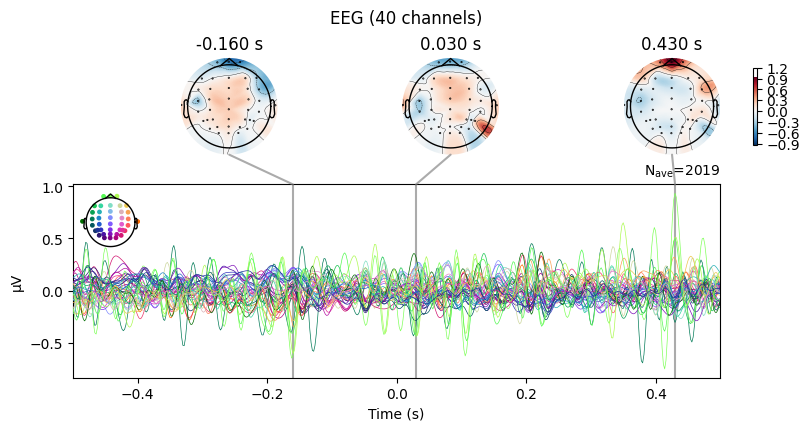

In [30]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Per-channel features

#### TakensEmbedding

In [31]:
if CHANNEL_READ_EMBEDDER_PARAMS_FROM_DISK:
    channel_embedders_params = [ ]
    for params_data in numpy.load(f"{subj}/{exp}/channel_embedders_params.npy"):
        channel_embedders_params.append(list(map(tuple, params_data)))
else:
    channel_searcher = gtda.time_series.SingleTakensEmbedding(
        parameters_type = 'search',
        time_delay = CHANNEL_MAX_TIME_DELAY,
        dimension = CHANNEL_MAX_DIMENSION,
        stride = CHANNEL_STRIDE,
        n_jobs = -1
    )
    channel_embedders_params = [ [ ] for _ in range(data.shape[1]) ]
    for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
        channel_searcher.fit(data[i, j, :])
        channel_embedders_params[j].append((channel_searcher.dimension_, channel_searcher.time_delay_))
    numpy.save(f"{subj}/{exp}/channel_embedders_params.npy", channel_embedders_params)

print(len(channel_embedders_params))
print(len(channel_embedders_params[0]))

  0%|          | 0/80760 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
channel_embedders = [ ]
for i in range(len(channel_embedders_params)):
    (dimension, time_delay), _ = collections.Counter(channel_embedders_params[i]).most_common(1)[0]
    attractor = gtda.time_series.SingleTakensEmbedding(
        parameters_type = 'fixed',
        time_delay = int(time_delay),
        dimension = int(dimension),
        stride = CHANNEL_STRIDE,
        n_jobs = -1
    )
    channel_embedders.append(attractor)
    
print(channel_embedders)
print(len(channel_embedders))

[SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=8), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=7), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=8), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=11), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=7), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=10), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type=

In [ ]:
channel_point_clouds = [ ]
for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
    channel_point_clouds.append(channel_embedders[j].fit_transform(data[i, j, :]))

print(len(channel_point_clouds))
print(channel_point_clouds[0].shape, channel_point_clouds[1].shape)
print(channel_point_clouds[40].shape, channel_point_clouds[41].shape)

  0%|          | 0/41840 [00:00<?, ?it/s]

41840
(157, 5) (146, 5)
(157, 5) (146, 5)


In [ ]:
channel_point_cloud_plot = gtda.plotting.plot_point_cloud(channel_point_clouds[print_obj])
display(channel_point_cloud_plot)
channel_point_cloud_plot.write_image(file = f"{subj}/{exp}/channel_point_cloud.svg", format = "svg")

#### VietorisRipsPersistence

In [ ]:
channel_persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = CHANNEL_HOMOLOGY_DIMENSIONS, n_jobs = -1)
channel_diagrams = channel_persistence.fit_transform(channel_point_clouds)
numpy.save(f"{subj}/{exp}/channel_diagrams.npy", channel_diagrams)
print(channel_diagrams.shape)

(41840, 195, 3)


In [ ]:
channel_diagram_plot = gtda.plotting.plot_diagram(channel_diagrams[print_obj])
display(channel_diagram_plot)
channel_diagram_plot.write_image(file = f"{subj}/{exp}/channel_diagram.svg", format = "svg")

#### FeatureCalculator

In [ ]:
n_channels = data.shape[1]
channel_features_raw = FeatureCalculator().calc_features(channel_diagrams)
columns = [ f"channel-{i}{feature_name}" for i in range(n_channels) for feature_name in channel_features_raw ]
channel_features = pandas.concat([ channel_features_raw.iloc[i::n_channels, :].reset_index(drop = True) for i in range(n_channels) ], axis = 1)
channel_features.columns = columns
channel_features.to_feather(f"{subj}/{exp}/channel_features.feather")
channel_features

Filtered diagrams: (41840, 180, 3)
N bins: 100


 lifetime: 100%|██████████| 41840/41840 [04:04<00:00, 171.01it/s]


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,channel-39 bd2 dim-2 mean,channel-39 bd2 dim-2 std,channel-39 bd2 dim-2 sum,channel-39 bd2 dim-2 percentile-25,channel-39 bd2 dim-2 median,channel-39 bd2 dim-2 percentile-75,channel-39 bd2 dim-2 kurtosis,channel-39 bd2 dim-2 skew,channel-39 bd2 dim-2 norm-1,channel-39 bd2 dim-2 norm-2
0,20.00,0.00,3.08,0.00,0.00,0.00,0.00,22.65,1.98,74.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.91,-0.49,0.00,0.00
1,25.00,0.00,3.63,0.00,0.00,0.00,0.00,36.29,0.72,74.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.22,0.75,0.00,0.00
2,14.00,0.00,2.52,0.00,0.00,0.00,0.00,21.62,1.42,62.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.51,2.26,0.00,0.00
3,10.00,0.00,1.87,0.00,0.00,0.00,0.00,24.06,-0.87,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,0.51,0.00,0.00
4,6.00,0.00,1.61,0.00,0.00,0.00,0.00,19.21,-2.15,44.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.43,0.63,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.00,0.00,1.69,0.00,0.00,0.00,0.00,34.35,3.92,48.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.05,0.10,0.00,0.00
1042,6.00,0.00,0.95,0.00,0.00,0.00,0.00,18.19,1.89,30.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,1.13,0.00,0.00
1043,12.00,0.00,1.85,0.00,0.00,0.00,0.00,24.86,2.85,46.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.85,1.42,0.00,0.00
1044,5.00,0.00,0.86,0.00,0.00,0.00,0.00,13.96,1.50,28.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.42,0.22,0.00,0.00


### PearsonDissimilarity

#### TakensEmbedding & PearsonDissimilarity

In [ ]:
dissim_matrixes = [ ]
for epoch in tqdm.tqdm(data):
    dissim_embedding = gtda.time_series.TakensEmbedding(
        dimension = DISSIM_DIMENSION,
        time_delay = DISSIM_TIME_DELAY,
        stride = DISSIM_STRIDE,
        flatten = False
    )
    dissim_windows = dissim_embedding.fit_transform(epoch).transpose(1, 2, 0)
    
    dissim = gtda.time_series.PearsonDissimilarity()
    dissim_matrix = dissim.fit_transform(dissim_windows)
    dissim_matrixes.append(dissim_matrix)

    epoch_ts = numpy.expand_dims(epoch.transpose(1, 0), 0)
    dissim_matrix = dissim.fit_transform(epoch_ts)
    dissim_matrixes.append(dissim_matrix)

dissim_matrixes = numpy.concatenate(dissim_matrixes, axis = 0)
print(dissim_matrixes.shape)

100%|██████████| 1046/1046 [00:01<00:00, 568.71it/s]

(25104, 40, 40)


In [ ]:
dissim_matrix_plot = gtda.plotting.plot_heatmap(dissim_matrixes[print_obj], colorscale = None, plotly_params = { 'autocolorscale': True })
display(dissim_matrix_plot)
dissim_matrix_plot.write_image(file = f"{subj}/{exp}/dissim_matrix.svg", format = "svg")

#### VietorisRipsPersistence

In [ ]:
dissim_persistence = gtda.homology.VietorisRipsPersistence(metric = "precomputed", homology_dimensions = DISSIM_HOMOLOGY_DIMENSIONS, n_jobs = -1)
dissim_diagrams = dissim_persistence.fit_transform(dissim_matrixes)
numpy.save(f"{subj}/{exp}/dissim_diagrams.npy", dissim_diagrams)
print(dissim_diagrams.shape)

(25104, 50, 3)


In [ ]:
dissim_diagram_plot = gtda.plotting.plot_diagram(dissim_diagrams[print_obj])
display(dissim_diagram_plot)
dissim_diagram_plot.write_image(file = f"{subj}/{exp}/dissim_diagram.svg", format = "svg")

#### FeatureCalculator

In [ ]:
n_dissim = dissim_diagrams.shape[0] // data.shape[0]
dissim_features_raw = FeatureCalculator().calc_features(dissim_diagrams)
columns = [ f"dissim-{i}{feature_name}" for i in range(n_dissim) for feature_name in dissim_features_raw ]
dissim_features = pandas.concat([ dissim_features_raw.iloc[i::n_dissim, :].reset_index(drop = True) for i in range(n_dissim) ], axis = 1)
dissim_features.columns = columns
dissim_features.to_feather(f"{subj}/{exp}/dissim_features.feather")
dissim_features

Filtered diagrams: (25104, 48, 3)
N bins: 100


 lifetime: 100%|██████████| 25104/25104 [04:26<00:00, 94.32it/s]


,dissim-0 betti dim-1 max,dissim-0 betti dim-1 mean,dissim-0 betti dim-1 std,dissim-0 betti dim-1 sum,dissim-0 betti dim-1 percentile-25,dissim-0 betti dim-1 median,dissim-0 betti dim-1 percentile-75,dissim-0 betti dim-1 kurtosis,dissim-0 betti dim-1 skew,dissim-0 betti dim-1 norm-1,...,dissim-23 bd2 dim-5 mean,dissim-23 bd2 dim-5 std,dissim-23 bd2 dim-5 sum,dissim-23 bd2 dim-5 percentile-25,dissim-23 bd2 dim-5 median,dissim-23 bd2 dim-5 percentile-75,dissim-23 bd2 dim-5 kurtosis,dissim-23 bd2 dim-5 skew,dissim-23 bd2 dim-5 norm-1,dissim-23 bd2 dim-5 norm-2
0,1.00,0.00,0.47,0.00,0.00,0.00,0.00,16.23,-2.31,16.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,0.00,0.28,0.00,0.00,0.00,0.00,9.38,0.00,8.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.00,0.00,0.38,0.00,0.00,0.00,0.00,10.13,-1.14,12.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,0.00,0.20,0.00,0.00,0.00,0.00,21.75,0.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2.00,0.00,0.40,0.00,0.00,0.00,0.00,12.47,0.00,12.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2.00,0.00,0.35,0.00,0.00,0.00,0.00,21.75,0.00,8.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1042,1.00,0.00,0.14,0.00,0.00,0.00,0.00,46.50,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1043,1.00,0.00,0.25,0.00,0.00,0.00,0.00,13.50,0.00,6.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,2.00,0.00,0.47,0.00,0.00,0.00,0.00,8.86,0.58,16.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Overall

#### TakensEmbedding

In [ ]:
overall_embedding = gtda.time_series.TakensEmbedding(
    dimension = OVERALL_DIMENSION,
    time_delay = OVERALL_TIME_DELAY,
    stride = OVERALL_STRIDE,
    flatten = True
)
overall_point_clouds = overall_embedding.fit_transform(data)
print(overall_point_clouds.shape)

(1046, 153, 200)


In [ ]:
overall_point_cloud_plot = gtda.plotting.plot_point_cloud(overall_point_clouds[print_obj])
display(overall_point_cloud_plot)
overall_point_cloud_plot.write_image(file = f"{subj}/{exp}/overall_point_cloud.svg", format = "svg")

#### VietorisRipsPersistence

In [ ]:
overall_persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = OVERALL_HOMOLOGY_DIMENSIONS, n_jobs = -1)
overall_diagrams = overall_persistence.fit_transform(overall_point_clouds)
numpy.save(f"{subj}/{exp}/overall_diagrams.npy", overall_diagrams)
print(overall_diagrams.shape)

(1046, 205, 3)


In [ ]:
overall_diagrams_plot = gtda.plotting.plot_diagram(overall_diagrams[print_obj])
display(overall_diagrams_plot)
overall_diagrams_plot.write_image(file = f"{subj}/{exp}/overall_diagram.svg", format = "svg")

#### FeatureCalculator

In [ ]:
overall_features = FeatureCalculator().calc_features(overall_diagrams, prefix = 'overall')
overall_features.to_feather(f"{subj}/{exp}/overall_features.feather")
overall_features

Filtered diagrams: (1046, 190, 3)
N bins: 100


overall lifetime: 100%|██████████| 1046/1046 [00:08<00:00, 121.77it/s]


,overall betti dim-1 max,overall betti dim-1 mean,overall betti dim-1 std,overall betti dim-1 sum,overall betti dim-1 percentile-25,overall betti dim-1 median,overall betti dim-1 percentile-75,overall betti dim-1 kurtosis,overall betti dim-1 skew,overall betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,14.00,0.00,2.78,0.00,0.00,0.00,0.00,20.08,-1.30,80.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.69,0.00,0.00
1,11.00,0.00,2.26,0.00,0.00,0.00,0.00,10.28,0.49,78.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.50,0.00,0.00
2,15.00,0.00,3.40,0.00,0.00,0.00,0.00,15.87,-1.03,94.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.36,0.00,0.00
3,8.00,0.00,2.04,0.00,0.00,0.00,0.00,13.39,-1.39,64.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.71,0.00,0.00
4,22.00,0.00,3.25,0.00,0.00,0.00,0.00,23.98,3.20,94.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,4.00,0.00,0.97,0.00,0.00,0.00,0.00,10.42,-0.39,36.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.51,0.04,0.00,0.00
1042,6.00,0.00,1.16,0.00,0.00,0.00,0.00,10.71,0.54,48.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.45,0.71,0.00,0.00
1043,3.00,0.00,0.93,0.00,0.00,0.00,0.00,5.54,0.15,36.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,5.00,0.00,0.78,0.00,0.00,0.00,0.00,20.10,2.44,22.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,0.00,0.00,0.00


### Features

In [ ]:
all_features = pandas.concat([ channel_features, dissim_features, overall_features ], axis = 1)
all_features.to_feather(f"{subj}/{exp}/all_features.feather")
all_features

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,20.00,0.00,3.08,0.00,0.00,0.00,0.00,22.65,1.98,74.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.69,0.00,0.00
1,25.00,0.00,3.63,0.00,0.00,0.00,0.00,36.29,0.72,74.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.50,0.00,0.00
2,14.00,0.00,2.52,0.00,0.00,0.00,0.00,21.62,1.42,62.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.36,0.00,0.00
3,10.00,0.00,1.87,0.00,0.00,0.00,0.00,24.06,-0.87,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.71,0.00,0.00
4,6.00,0.00,1.61,0.00,0.00,0.00,0.00,19.21,-2.15,44.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.00,0.00,1.69,0.00,0.00,0.00,0.00,34.35,3.92,48.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.51,0.04,0.00,0.00
1042,6.00,0.00,0.95,0.00,0.00,0.00,0.00,18.19,1.89,30.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.45,0.71,0.00,0.00
1043,12.00,0.00,1.85,0.00,0.00,0.00,0.00,24.86,2.85,46.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,5.00,0.00,0.86,0.00,0.00,0.00,0.00,13.96,1.50,28.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,0.00,0.00,0.00


#### PCA

In [ ]:
features_pca = FeatureCalculator().pca(all_features, scale = True, n_comp = 0.5)
print(features_pca.shape)
pandas.DataFrame(features_pca)

Components: 0.5
Explained variance: 0.5
[0.092, 0.034, 0.024, 0.017, 0.013, 0.013, 0.011, 0.01, 0.009, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003]
(1046, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-17.88,-49.66,7.27,-17.67,9.41,-4.28,-15.56,24.09,9.53,0.44,...,7.79,13.99,8.99,-1.94,0.79,-3.58,0.76,13.72,2.02,-0.55
1,-8.79,-39.22,0.48,-22.23,19.60,-4.17,-19.85,2.00,-0.23,-9.25,...,-1.39,15.94,14.34,0.78,-7.58,-1.31,5.00,11.05,-5.59,-4.98
2,-8.81,-37.28,6.28,-8.86,15.92,-6.08,-25.88,-0.24,-6.09,-5.61,...,-13.47,13.90,4.09,-1.62,-9.26,-4.35,-8.83,10.33,-11.23,-9.84
3,9.74,-41.69,2.96,-20.61,0.54,-0.60,-16.66,-4.07,5.91,-2.91,...,-6.37,4.96,0.71,-0.13,3.33,-3.23,-2.62,1.19,-2.87,4.51
4,-14.23,-43.57,1.45,-18.12,0.42,-7.60,-14.57,-14.26,-13.85,-11.77,...,-7.36,8.29,0.48,-7.41,0.67,-2.83,0.89,-6.66,2.57,-10.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,53.79,29.07,8.47,12.61,-5.88,-5.44,-3.62,-3.25,8.42,-29.73,...,2.48,-2.00,-16.30,8.87,5.86,-0.29,7.31,-0.87,0.13,-5.28
1042,77.61,62.68,27.87,5.05,-8.91,40.49,-33.21,-18.80,15.10,24.49,...,-1.31,-1.14,19.99,31.69,-22.08,-18.93,-18.07,-15.16,3.13,-16.08
1043,2.84,15.46,-11.08,-3.93,-0.17,15.27,-3.11,-2.15,9.08,-2.55,...,-0.67,-5.17,11.86,3.00,-5.57,2.61,-3.04,11.28,-2.62,-0.78
1044,-34.49,17.45,13.23,-11.91,-26.38,9.78,3.83,-3.98,-1.39,-16.83,...,10.02,-4.87,-3.98,-1.87,3.53,-14.68,-11.52,5.57,-0.04,-3.91


#### Save

In [ ]:
final_features = pandas.DataFrame(features_pca)
final_features.to_feather(f"{subj}/{exp}/features.feather")
final_features

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-17.88,-49.66,7.27,-17.67,9.41,-4.28,-15.56,24.09,9.53,0.44,...,7.79,13.99,8.99,-1.94,0.79,-3.58,0.76,13.72,2.02,-0.55
1,-8.79,-39.22,0.48,-22.23,19.60,-4.17,-19.85,2.00,-0.23,-9.25,...,-1.39,15.94,14.34,0.78,-7.58,-1.31,5.00,11.05,-5.59,-4.98
2,-8.81,-37.28,6.28,-8.86,15.92,-6.08,-25.88,-0.24,-6.09,-5.61,...,-13.47,13.90,4.09,-1.62,-9.26,-4.35,-8.83,10.33,-11.23,-9.84
3,9.74,-41.69,2.96,-20.61,0.54,-0.60,-16.66,-4.07,5.91,-2.91,...,-6.37,4.96,0.71,-0.13,3.33,-3.23,-2.62,1.19,-2.87,4.51
4,-14.23,-43.57,1.45,-18.12,0.42,-7.60,-14.57,-14.26,-13.85,-11.77,...,-7.36,8.29,0.48,-7.41,0.67,-2.83,0.89,-6.66,2.57,-10.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,53.79,29.07,8.47,12.61,-5.88,-5.44,-3.62,-3.25,8.42,-29.73,...,2.48,-2.00,-16.30,8.87,5.86,-0.29,7.31,-0.87,0.13,-5.28
1042,77.61,62.68,27.87,5.05,-8.91,40.49,-33.21,-18.80,15.10,24.49,...,-1.31,-1.14,19.99,31.69,-22.08,-18.93,-18.07,-15.16,3.13,-16.08
1043,2.84,15.46,-11.08,-3.93,-0.17,15.27,-3.11,-2.15,9.08,-2.55,...,-0.67,-5.17,11.86,3.00,-5.57,2.61,-3.04,11.28,-2.62,-0.78
1044,-34.49,17.45,13.23,-11.91,-26.38,9.78,3.83,-3.98,-1.39,-16.83,...,10.02,-4.87,-3.98,-1.87,3.53,-14.68,-11.52,5.57,-0.04,-3.91
